# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

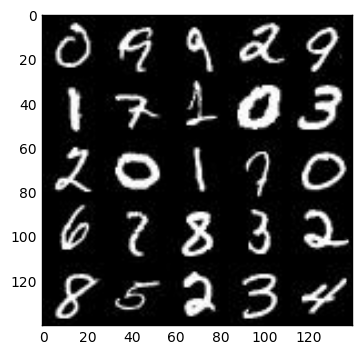

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

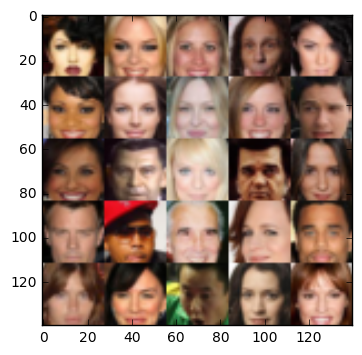

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_inputs = tf.placeholder(tf.float32,(None, image_width, image_height, image_channels), name = 'inputs_real')
    
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name = 'inputs_z')
    
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        relu1 = tf.maximum(alpha * x1, x1)
        # now 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same', kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #now 7x7x256
        
        
        flat = tf.reshape(relu2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # here 7x7x256
        
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #here 14x14x128

        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding="SAME")
        #here 28x28x3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_operation = tf.train.AdamOptimizer(learning_rate,beta1).minimize(d_loss, var_list=d_vars)
    g_train_operation = tf.train.AdamOptimizer(learning_rate,beta1).minimize(g_loss, var_list=g_vars)
    return d_train_operation, g_train_operation


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, image_width, image_height, image_channels = data_shape
    
    # Model inputse
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Losses
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Optimization
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Steps
    steps = 0
    
    # Number of images to print
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Multiply batch_images by 2.0 since the dataset ranges from -0.5 to 0.5
                batch_images = batch_images*2.0
                
                # Random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                # Increment the batch count
                steps += 1

                # Print the d_train_loss and g_train_loss every 10 batches
                if (steps % 10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                # Print the generator output every 100 batches
                if (steps % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8234... Generator Loss: 0.7828
Epoch 1/2... Discriminator Loss: 0.7188... Generator Loss: 1.2190
Epoch 1/2... Discriminator Loss: 1.5566... Generator Loss: 0.3140
Epoch 1/2... Discriminator Loss: 0.9237... Generator Loss: 0.6703
Epoch 1/2... Discriminator Loss: 0.6070... Generator Loss: 1.3999
Epoch 1/2... Discriminator Loss: 0.8364... Generator Loss: 1.5426
Epoch 1/2... Discriminator Loss: 0.8019... Generator Loss: 1.1003
Epoch 1/2... Discriminator Loss: 0.9354... Generator Loss: 0.7198
Epoch 1/2... Discriminator Loss: 1.0648... Generator Loss: 0.5882
Epoch 1/2... Discriminator Loss: 1.0137... Generator Loss: 1.5416


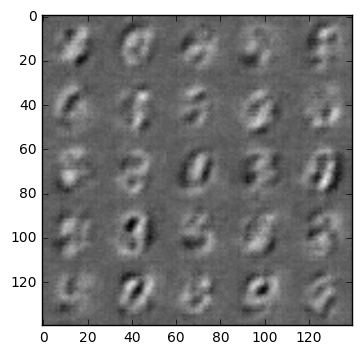

Epoch 1/2... Discriminator Loss: 0.8964... Generator Loss: 0.9401
Epoch 1/2... Discriminator Loss: 0.9480... Generator Loss: 1.7059
Epoch 1/2... Discriminator Loss: 0.9273... Generator Loss: 1.3670
Epoch 1/2... Discriminator Loss: 0.8922... Generator Loss: 1.3307
Epoch 1/2... Discriminator Loss: 0.9235... Generator Loss: 0.8312
Epoch 1/2... Discriminator Loss: 0.9402... Generator Loss: 1.1587
Epoch 1/2... Discriminator Loss: 0.9449... Generator Loss: 0.8794
Epoch 1/2... Discriminator Loss: 0.8670... Generator Loss: 1.2542
Epoch 1/2... Discriminator Loss: 0.8996... Generator Loss: 0.8005
Epoch 1/2... Discriminator Loss: 0.8934... Generator Loss: 1.0380


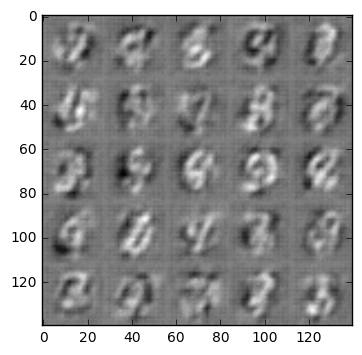

Epoch 1/2... Discriminator Loss: 0.9208... Generator Loss: 1.5496
Epoch 1/2... Discriminator Loss: 0.9743... Generator Loss: 0.6875
Epoch 1/2... Discriminator Loss: 1.2102... Generator Loss: 0.4624
Epoch 1/2... Discriminator Loss: 1.0724... Generator Loss: 1.6676
Epoch 1/2... Discriminator Loss: 0.9179... Generator Loss: 0.7494
Epoch 1/2... Discriminator Loss: 0.9647... Generator Loss: 1.5634
Epoch 1/2... Discriminator Loss: 0.8183... Generator Loss: 1.0016
Epoch 1/2... Discriminator Loss: 1.0193... Generator Loss: 0.6040
Epoch 1/2... Discriminator Loss: 0.7761... Generator Loss: 1.2746
Epoch 1/2... Discriminator Loss: 0.8205... Generator Loss: 0.9980


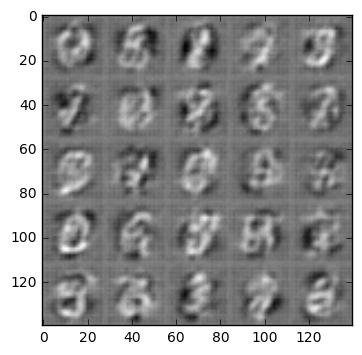

Epoch 1/2... Discriminator Loss: 0.8674... Generator Loss: 1.6947
Epoch 1/2... Discriminator Loss: 0.8301... Generator Loss: 0.8236
Epoch 1/2... Discriminator Loss: 0.7327... Generator Loss: 1.2163
Epoch 1/2... Discriminator Loss: 0.7420... Generator Loss: 1.2422
Epoch 1/2... Discriminator Loss: 0.7818... Generator Loss: 2.0183
Epoch 1/2... Discriminator Loss: 0.6820... Generator Loss: 1.1731
Epoch 1/2... Discriminator Loss: 0.7398... Generator Loss: 1.4282
Epoch 1/2... Discriminator Loss: 0.7092... Generator Loss: 1.7777
Epoch 1/2... Discriminator Loss: 0.7808... Generator Loss: 1.3631
Epoch 1/2... Discriminator Loss: 0.7401... Generator Loss: 0.9663


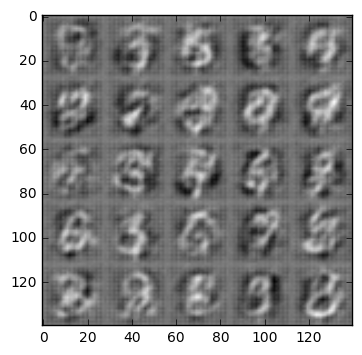

Epoch 1/2... Discriminator Loss: 0.7669... Generator Loss: 0.8273
Epoch 1/2... Discriminator Loss: 0.7065... Generator Loss: 0.9738
Epoch 1/2... Discriminator Loss: 0.6950... Generator Loss: 1.5002
Epoch 1/2... Discriminator Loss: 0.7107... Generator Loss: 1.3236
Epoch 1/2... Discriminator Loss: 0.6605... Generator Loss: 1.1832
Epoch 1/2... Discriminator Loss: 0.8673... Generator Loss: 0.7632
Epoch 1/2... Discriminator Loss: 0.8385... Generator Loss: 2.6028
Epoch 1/2... Discriminator Loss: 0.7103... Generator Loss: 1.2951
Epoch 1/2... Discriminator Loss: 0.6907... Generator Loss: 1.6450
Epoch 1/2... Discriminator Loss: 0.7455... Generator Loss: 1.0378


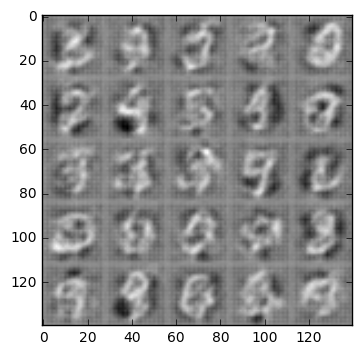

Epoch 1/2... Discriminator Loss: 0.5682... Generator Loss: 1.5308
Epoch 1/2... Discriminator Loss: 1.0369... Generator Loss: 2.6228
Epoch 1/2... Discriminator Loss: 0.8337... Generator Loss: 0.7959
Epoch 1/2... Discriminator Loss: 0.6636... Generator Loss: 1.1722
Epoch 1/2... Discriminator Loss: 0.8437... Generator Loss: 2.3029
Epoch 1/2... Discriminator Loss: 0.7260... Generator Loss: 1.1550
Epoch 1/2... Discriminator Loss: 1.0285... Generator Loss: 0.5781
Epoch 1/2... Discriminator Loss: 1.0762... Generator Loss: 0.5452
Epoch 1/2... Discriminator Loss: 0.8921... Generator Loss: 0.6972
Epoch 1/2... Discriminator Loss: 0.8182... Generator Loss: 1.7830


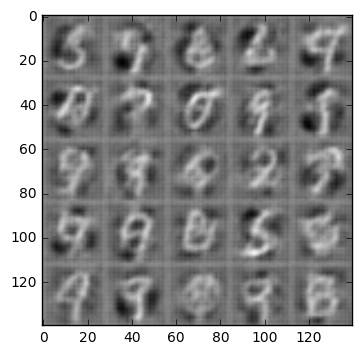

Epoch 1/2... Discriminator Loss: 0.7762... Generator Loss: 1.1248
Epoch 1/2... Discriminator Loss: 0.7825... Generator Loss: 0.8674
Epoch 1/2... Discriminator Loss: 0.8639... Generator Loss: 2.3184
Epoch 1/2... Discriminator Loss: 0.7987... Generator Loss: 0.8599
Epoch 1/2... Discriminator Loss: 0.8291... Generator Loss: 1.0524
Epoch 1/2... Discriminator Loss: 0.9357... Generator Loss: 2.2425
Epoch 1/2... Discriminator Loss: 0.7662... Generator Loss: 1.1961
Epoch 1/2... Discriminator Loss: 1.9555... Generator Loss: 0.2103
Epoch 1/2... Discriminator Loss: 1.0581... Generator Loss: 0.5833
Epoch 1/2... Discriminator Loss: 0.7468... Generator Loss: 1.7280


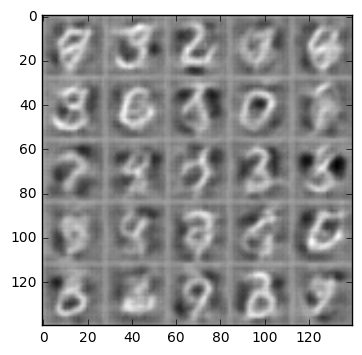

Epoch 1/2... Discriminator Loss: 0.7626... Generator Loss: 1.6503
Epoch 1/2... Discriminator Loss: 0.8271... Generator Loss: 1.1603
Epoch 1/2... Discriminator Loss: 0.9289... Generator Loss: 0.8187
Epoch 1/2... Discriminator Loss: 0.7521... Generator Loss: 1.3456
Epoch 1/2... Discriminator Loss: 0.9275... Generator Loss: 0.7816
Epoch 1/2... Discriminator Loss: 0.8840... Generator Loss: 1.2577
Epoch 1/2... Discriminator Loss: 0.9524... Generator Loss: 0.6993
Epoch 1/2... Discriminator Loss: 1.0276... Generator Loss: 0.6523
Epoch 1/2... Discriminator Loss: 0.8732... Generator Loss: 1.7255
Epoch 1/2... Discriminator Loss: 0.8511... Generator Loss: 1.3685


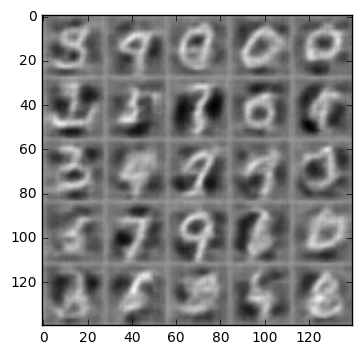

Epoch 1/2... Discriminator Loss: 0.7868... Generator Loss: 0.9911
Epoch 1/2... Discriminator Loss: 0.8209... Generator Loss: 1.8134
Epoch 1/2... Discriminator Loss: 0.9749... Generator Loss: 1.6787
Epoch 1/2... Discriminator Loss: 0.9632... Generator Loss: 0.8241
Epoch 1/2... Discriminator Loss: 0.9965... Generator Loss: 0.6143
Epoch 1/2... Discriminator Loss: 1.0792... Generator Loss: 0.5960
Epoch 1/2... Discriminator Loss: 0.9101... Generator Loss: 1.5285
Epoch 1/2... Discriminator Loss: 1.2103... Generator Loss: 0.5299
Epoch 1/2... Discriminator Loss: 0.8398... Generator Loss: 1.3370
Epoch 1/2... Discriminator Loss: 1.2883... Generator Loss: 0.4253


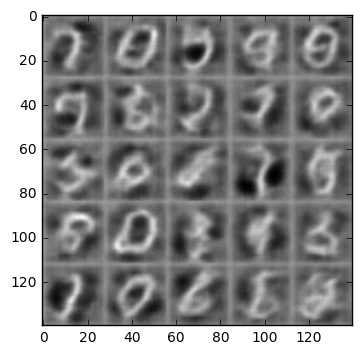

Epoch 1/2... Discriminator Loss: 1.1040... Generator Loss: 0.6265
Epoch 1/2... Discriminator Loss: 0.8339... Generator Loss: 1.3023
Epoch 1/2... Discriminator Loss: 0.9285... Generator Loss: 0.8350
Epoch 2/2... Discriminator Loss: 0.8471... Generator Loss: 0.9644
Epoch 2/2... Discriminator Loss: 0.9088... Generator Loss: 1.0942
Epoch 2/2... Discriminator Loss: 0.9885... Generator Loss: 1.7150
Epoch 2/2... Discriminator Loss: 1.1145... Generator Loss: 1.8313
Epoch 2/2... Discriminator Loss: 0.9809... Generator Loss: 0.6718
Epoch 2/2... Discriminator Loss: 0.8019... Generator Loss: 0.9977
Epoch 2/2... Discriminator Loss: 0.8896... Generator Loss: 1.2462


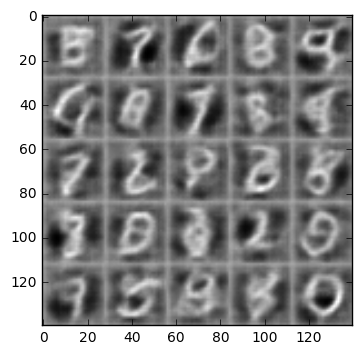

Epoch 2/2... Discriminator Loss: 0.8318... Generator Loss: 1.8293
Epoch 2/2... Discriminator Loss: 0.8771... Generator Loss: 1.0015
Epoch 2/2... Discriminator Loss: 0.8862... Generator Loss: 1.1580
Epoch 2/2... Discriminator Loss: 0.8619... Generator Loss: 1.2911
Epoch 2/2... Discriminator Loss: 0.8574... Generator Loss: 0.9333
Epoch 2/2... Discriminator Loss: 1.0802... Generator Loss: 0.6679
Epoch 2/2... Discriminator Loss: 0.9253... Generator Loss: 1.6867
Epoch 2/2... Discriminator Loss: 1.2214... Generator Loss: 0.4660
Epoch 2/2... Discriminator Loss: 0.7856... Generator Loss: 1.1699
Epoch 2/2... Discriminator Loss: 1.0669... Generator Loss: 1.8966


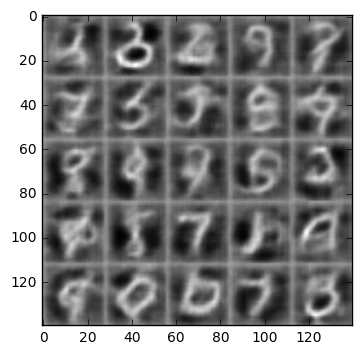

Epoch 2/2... Discriminator Loss: 0.7985... Generator Loss: 1.0556
Epoch 2/2... Discriminator Loss: 0.8827... Generator Loss: 1.0185
Epoch 2/2... Discriminator Loss: 1.0662... Generator Loss: 0.5988
Epoch 2/2... Discriminator Loss: 1.0941... Generator Loss: 0.6095
Epoch 2/2... Discriminator Loss: 0.8586... Generator Loss: 0.7923
Epoch 2/2... Discriminator Loss: 0.8100... Generator Loss: 0.9893
Epoch 2/2... Discriminator Loss: 0.9706... Generator Loss: 2.0686
Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 0.9263
Epoch 2/2... Discriminator Loss: 0.9879... Generator Loss: 0.7129
Epoch 2/2... Discriminator Loss: 0.8851... Generator Loss: 0.8970


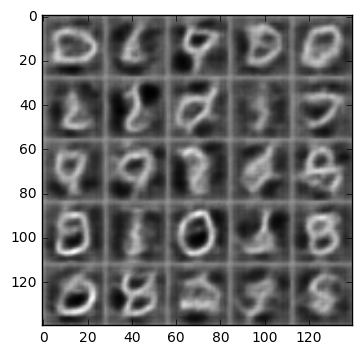

Epoch 2/2... Discriminator Loss: 0.8433... Generator Loss: 0.7838
Epoch 2/2... Discriminator Loss: 1.2014... Generator Loss: 0.4716
Epoch 2/2... Discriminator Loss: 1.0848... Generator Loss: 0.5524
Epoch 2/2... Discriminator Loss: 1.0783... Generator Loss: 0.5608
Epoch 2/2... Discriminator Loss: 0.8386... Generator Loss: 1.0350
Epoch 2/2... Discriminator Loss: 0.9070... Generator Loss: 1.3748
Epoch 2/2... Discriminator Loss: 1.2357... Generator Loss: 2.1887
Epoch 2/2... Discriminator Loss: 0.8237... Generator Loss: 0.8505
Epoch 2/2... Discriminator Loss: 0.6640... Generator Loss: 1.2396
Epoch 2/2... Discriminator Loss: 0.9223... Generator Loss: 0.7375


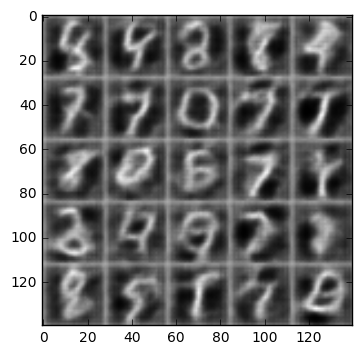

Epoch 2/2... Discriminator Loss: 0.8495... Generator Loss: 1.3656
Epoch 2/2... Discriminator Loss: 0.9710... Generator Loss: 1.2016
Epoch 2/2... Discriminator Loss: 1.0446... Generator Loss: 0.7042
Epoch 2/2... Discriminator Loss: 0.8224... Generator Loss: 1.2257
Epoch 2/2... Discriminator Loss: 0.7752... Generator Loss: 1.1299
Epoch 2/2... Discriminator Loss: 0.8666... Generator Loss: 0.7923
Epoch 2/2... Discriminator Loss: 0.8213... Generator Loss: 1.2752
Epoch 2/2... Discriminator Loss: 0.8211... Generator Loss: 1.2939
Epoch 2/2... Discriminator Loss: 0.7844... Generator Loss: 1.1278
Epoch 2/2... Discriminator Loss: 0.8649... Generator Loss: 0.7465


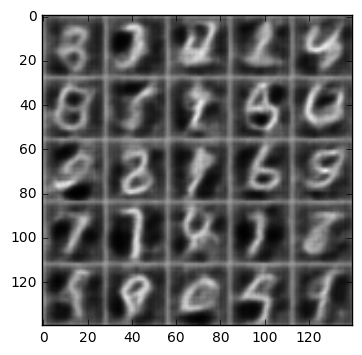

Epoch 2/2... Discriminator Loss: 1.0946... Generator Loss: 0.5318
Epoch 2/2... Discriminator Loss: 0.7856... Generator Loss: 0.9918
Epoch 2/2... Discriminator Loss: 0.7901... Generator Loss: 1.0026
Epoch 2/2... Discriminator Loss: 0.7186... Generator Loss: 1.2176
Epoch 2/2... Discriminator Loss: 0.8648... Generator Loss: 1.4773
Epoch 2/2... Discriminator Loss: 0.7556... Generator Loss: 1.1158
Epoch 2/2... Discriminator Loss: 0.7581... Generator Loss: 1.2952
Epoch 2/2... Discriminator Loss: 0.9784... Generator Loss: 0.6399
Epoch 2/2... Discriminator Loss: 0.8689... Generator Loss: 0.7970
Epoch 2/2... Discriminator Loss: 0.9483... Generator Loss: 1.8089


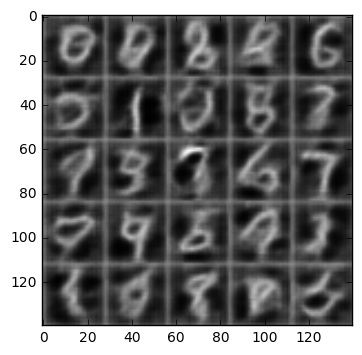

Epoch 2/2... Discriminator Loss: 0.9367... Generator Loss: 0.8299
Epoch 2/2... Discriminator Loss: 0.8953... Generator Loss: 0.8690
Epoch 2/2... Discriminator Loss: 0.7623... Generator Loss: 1.1997
Epoch 2/2... Discriminator Loss: 0.9127... Generator Loss: 0.7526
Epoch 2/2... Discriminator Loss: 0.7089... Generator Loss: 1.0924
Epoch 2/2... Discriminator Loss: 0.7584... Generator Loss: 1.1912
Epoch 2/2... Discriminator Loss: 0.9446... Generator Loss: 0.6979
Epoch 2/2... Discriminator Loss: 0.7394... Generator Loss: 1.0974
Epoch 2/2... Discriminator Loss: 1.0023... Generator Loss: 2.0897
Epoch 2/2... Discriminator Loss: 0.7808... Generator Loss: 1.6670


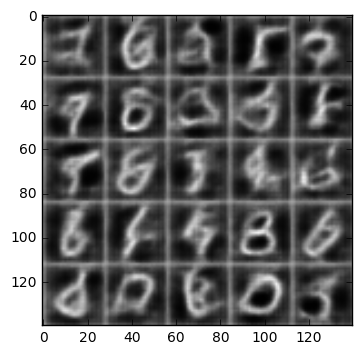

Epoch 2/2... Discriminator Loss: 0.7620... Generator Loss: 1.4638
Epoch 2/2... Discriminator Loss: 1.0071... Generator Loss: 2.2461
Epoch 2/2... Discriminator Loss: 0.6577... Generator Loss: 1.1347
Epoch 2/2... Discriminator Loss: 0.6704... Generator Loss: 1.1737
Epoch 2/2... Discriminator Loss: 0.6926... Generator Loss: 1.0227
Epoch 2/2... Discriminator Loss: 0.8739... Generator Loss: 0.7842
Epoch 2/2... Discriminator Loss: 0.7615... Generator Loss: 1.8488
Epoch 2/2... Discriminator Loss: 0.6215... Generator Loss: 1.2479
Epoch 2/2... Discriminator Loss: 0.9792... Generator Loss: 2.2105
Epoch 2/2... Discriminator Loss: 1.2641... Generator Loss: 0.4678


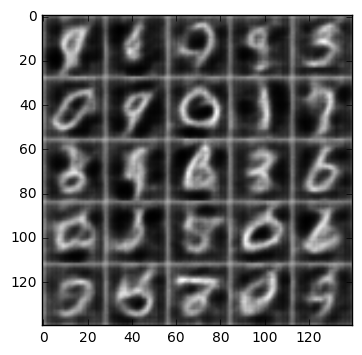

Epoch 2/2... Discriminator Loss: 0.7588... Generator Loss: 1.1795
Epoch 2/2... Discriminator Loss: 0.6857... Generator Loss: 1.2874
Epoch 2/2... Discriminator Loss: 0.7912... Generator Loss: 0.8579
Epoch 2/2... Discriminator Loss: 0.8257... Generator Loss: 1.6845
Epoch 2/2... Discriminator Loss: 0.7309... Generator Loss: 1.1352
Epoch 2/2... Discriminator Loss: 0.7978... Generator Loss: 1.8966
Epoch 2/2... Discriminator Loss: 1.1174... Generator Loss: 2.3781
Epoch 2/2... Discriminator Loss: 0.9683... Generator Loss: 0.6983
Epoch 2/2... Discriminator Loss: 0.8829... Generator Loss: 2.2597
Epoch 2/2... Discriminator Loss: 0.6731... Generator Loss: 1.8462


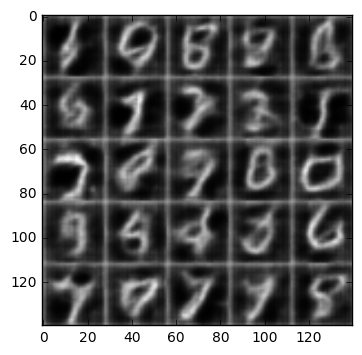

Epoch 2/2... Discriminator Loss: 0.5741... Generator Loss: 1.5629
Epoch 2/2... Discriminator Loss: 0.7693... Generator Loss: 0.9250
Epoch 2/2... Discriminator Loss: 0.7120... Generator Loss: 1.1747
Epoch 2/2... Discriminator Loss: 1.6660... Generator Loss: 0.3072
Epoch 2/2... Discriminator Loss: 0.7223... Generator Loss: 1.1534
Epoch 2/2... Discriminator Loss: 0.7624... Generator Loss: 1.2302
Epoch 2/2... Discriminator Loss: 0.6988... Generator Loss: 1.0586


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 0.6604... Generator Loss: 1.0092
Epoch 1/1... Discriminator Loss: 0.5106... Generator Loss: 1.2702
Epoch 1/1... Discriminator Loss: 0.4104... Generator Loss: 1.3815
Epoch 1/1... Discriminator Loss: 0.2702... Generator Loss: 1.8653
Epoch 1/1... Discriminator Loss: 0.3427... Generator Loss: 1.8858
Epoch 1/1... Discriminator Loss: 0.2975... Generator Loss: 1.8969
Epoch 1/1... Discriminator Loss: 0.2913... Generator Loss: 2.4465
Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 3.1466
Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 1.5729


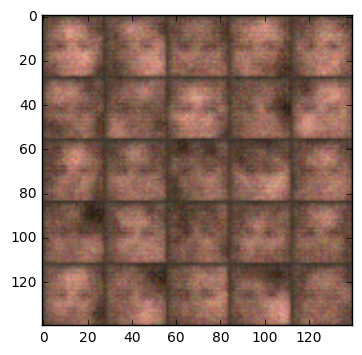

Epoch 1/1... Discriminator Loss: 0.7101... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 0.8710... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 2.1814
Epoch 1/1... Discriminator Loss: 0.8679... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 0.8100... Generator Loss: 2.1584
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 1.9612
Epoch 1/1... Discriminator Loss: 0.6279... Generator Loss: 1.6607
Epoch 1/1... Discriminator Loss: 0.7262... Generator Loss: 1.1555


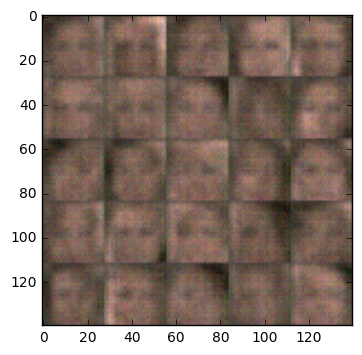

Epoch 1/1... Discriminator Loss: 0.9812... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 1.1547
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 1.7226
Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 1.3790
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 2.5777
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 1.9082
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 1.4086


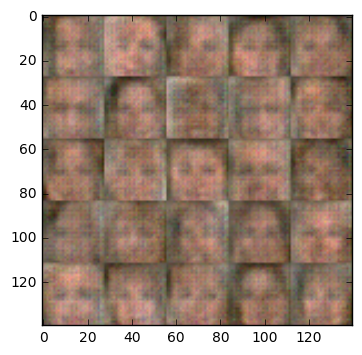

Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 1.7107
Epoch 1/1... Discriminator Loss: 0.8329... Generator Loss: 1.2100
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 1.6838
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 1.2559
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 1.5133
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 0.8323... Generator Loss: 1.2286
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 1.1542


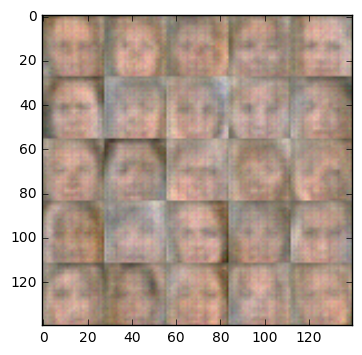

Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 1.7148
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.2389
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 0.5550
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 1.1485
Epoch 1/1... Discriminator Loss: 0.7767... Generator Loss: 1.6609
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 1.5388
Epoch 1/1... Discriminator Loss: 0.8238... Generator Loss: 1.4867


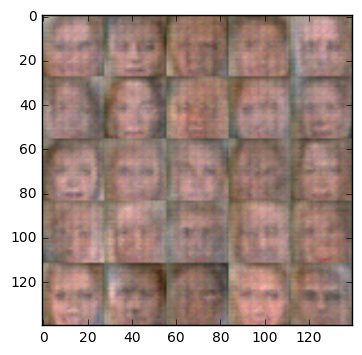

Epoch 1/1... Discriminator Loss: 0.7962... Generator Loss: 1.3675
Epoch 1/1... Discriminator Loss: 0.8181... Generator Loss: 1.2723
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.4066
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.5935... Generator Loss: 0.3252
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 1.2627
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 1.3115
Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 1.0359


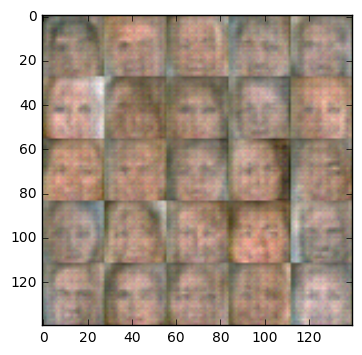

Epoch 1/1... Discriminator Loss: 0.8234... Generator Loss: 1.0343
Epoch 1/1... Discriminator Loss: 0.8740... Generator Loss: 1.4463
Epoch 1/1... Discriminator Loss: 1.0607... Generator Loss: 1.9347
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 1.4621
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 1.7876
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 1.3051
Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 1.6951


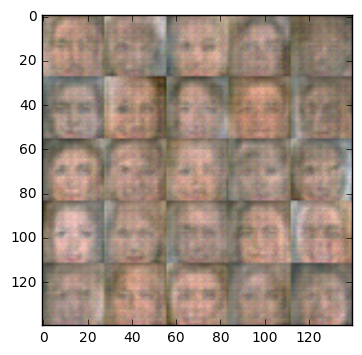

Epoch 1/1... Discriminator Loss: 0.8029... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 1.4233
Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 1.0898
Epoch 1/1... Discriminator Loss: 0.5996... Generator Loss: 1.2996
Epoch 1/1... Discriminator Loss: 0.9637... Generator Loss: 1.1032
Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 1.4276
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 1.9337
Epoch 1/1... Discriminator Loss: 0.7996... Generator Loss: 1.5256
Epoch 1/1... Discriminator Loss: 0.8133... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 1.1568


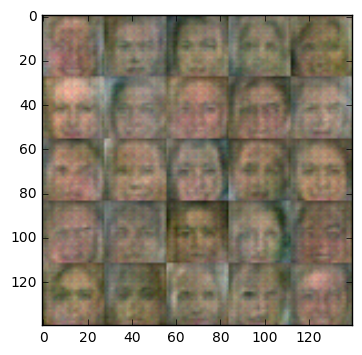

Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 1.1712
Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 1.2139
Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 1.2315
Epoch 1/1... Discriminator Loss: 0.7440... Generator Loss: 1.3494
Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 1.2592
Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 0.9392
Epoch 1/1... Discriminator Loss: 0.7112... Generator Loss: 1.1934


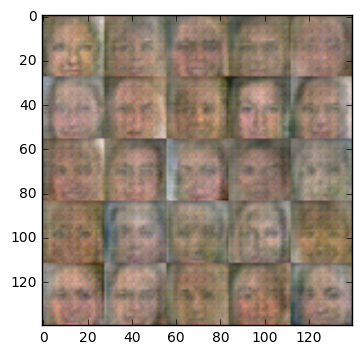

Epoch 1/1... Discriminator Loss: 0.9113... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 0.6719... Generator Loss: 1.1607
Epoch 1/1... Discriminator Loss: 0.8768... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 2.9570
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 0.9835
Epoch 1/1... Discriminator Loss: 0.7334... Generator Loss: 1.1052
Epoch 1/1... Discriminator Loss: 0.8458... Generator Loss: 1.2487
Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 1.5194
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 0.6824... Generator Loss: 1.1635


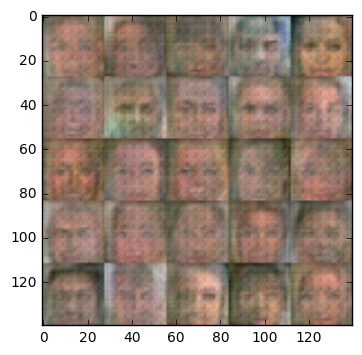

Epoch 1/1... Discriminator Loss: 0.6493... Generator Loss: 1.1438
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 1.2053
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.4854
Epoch 1/1... Discriminator Loss: 0.6992... Generator Loss: 1.5889
Epoch 1/1... Discriminator Loss: 0.8993... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 0.8182... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.4360
Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 1.1643
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 0.6563


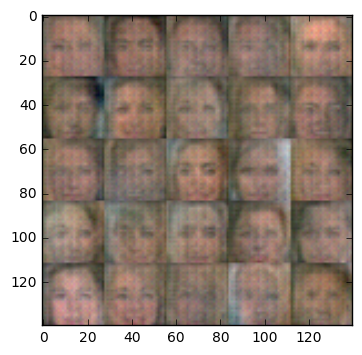

Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.4868
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 0.8518... Generator Loss: 1.0864
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 0.9616
Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 1.1375
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 0.9482
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 0.8300... Generator Loss: 1.0514


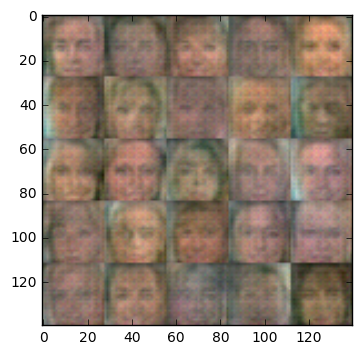

Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.4740
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 0.9936
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 1.3686
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 1.0596
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.8862


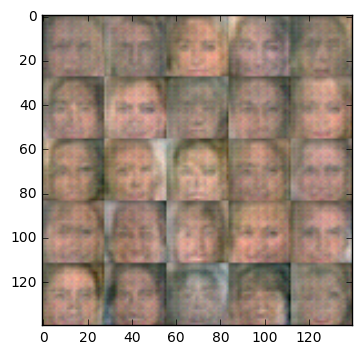

Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.0777
Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 1.0660
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 1.2481
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 1.2181
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 1.5463
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.4442
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 1.7162
Epoch 1/1... Discriminator Loss: 1.0120... Generator Loss: 0.9848


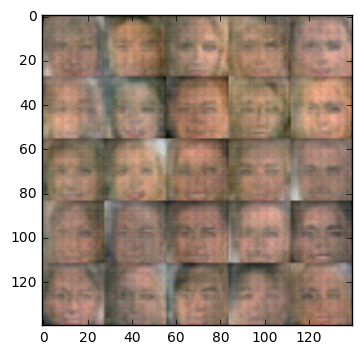

Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 1.1346
Epoch 1/1... Discriminator Loss: 0.8559... Generator Loss: 1.3136
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 1.5793
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 1.0153
Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 1.5201
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 1.1951
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 1.1995
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 1.2702
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.6967


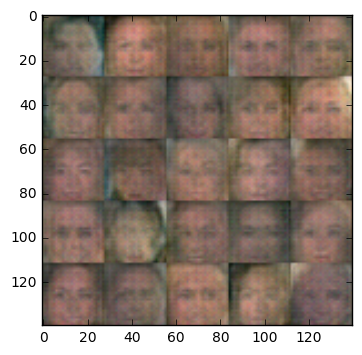

Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 1.5620
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 0.9946
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 1.5156
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 1.1357
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.7289


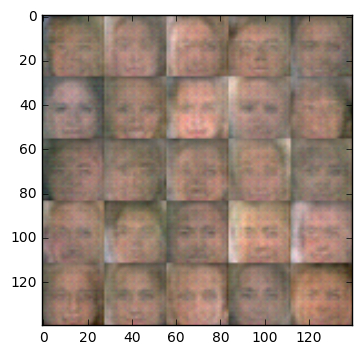

Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.0126
Epoch 1/1... Discriminator Loss: 0.9057... Generator Loss: 1.2924
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 1.0369
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 1.0441
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 1.3698
Epoch 1/1... Discriminator Loss: 0.7598... Generator Loss: 1.2891
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 0.8623... Generator Loss: 1.4578
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 0.9005


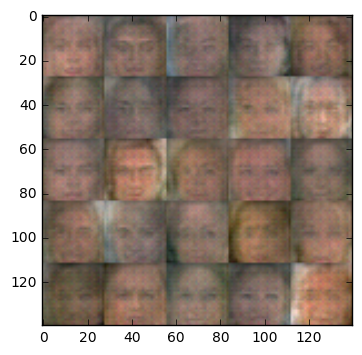

Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 1.2333
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.4388
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 1.0355
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 0.8466


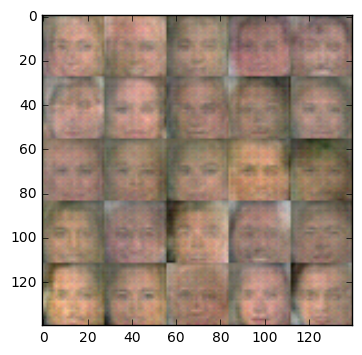

Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 1.4236
Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 1.1631
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 1.0887
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 1.4108
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 1.4385
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 1.9241
Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 1.2549


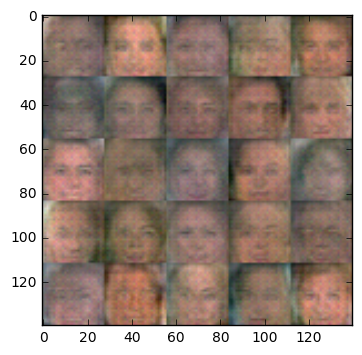

Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 1.0496
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 1.6080
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 1.3856


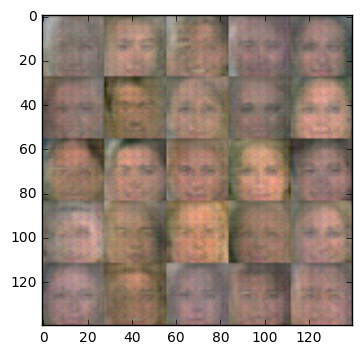

Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 1.6044
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 2.0968
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 1.0230
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 0.9836


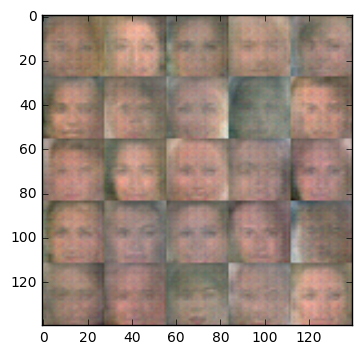

Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 0.7069... Generator Loss: 1.6165
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 0.9547


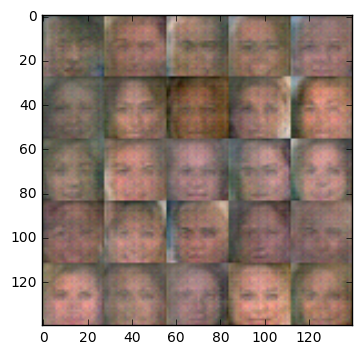

Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.4234
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 1.4838
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 1.1334
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.5760
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 2.1618


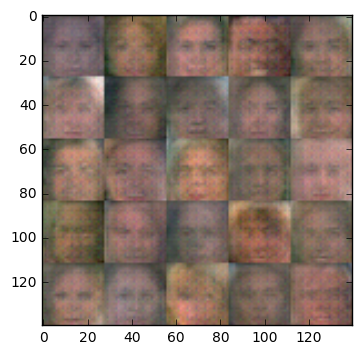

Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 1.5072
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 1.1732
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 1.0528
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.4149
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 1.0589
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.5941


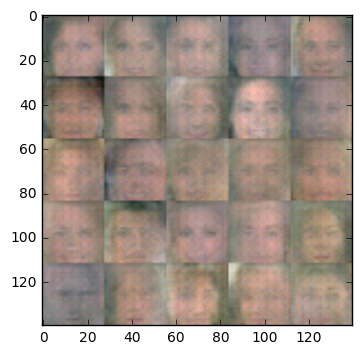

Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 1.8623
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.4440
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 1.3971
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 1.4601


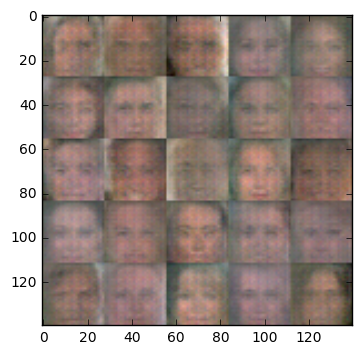

Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 1.3391
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.3903
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 1.2274
Epoch 1/1... Discriminator Loss: 0.8172... Generator Loss: 1.1816
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 1.3428
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 1.1094
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 1.3754
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 0.7958


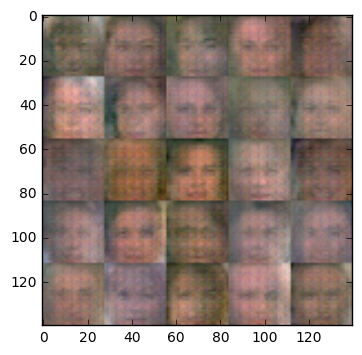

Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 1.3620
Epoch 1/1... Discriminator Loss: 0.8776... Generator Loss: 1.1034
Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 0.3623
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 1.2703
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.4384


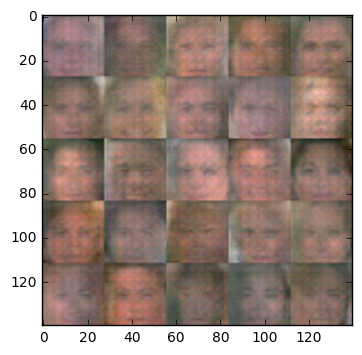

Epoch 1/1... Discriminator Loss: 1.0408... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 1.2937
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 1.3117
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 1.2440
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 2.0672
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 0.7101


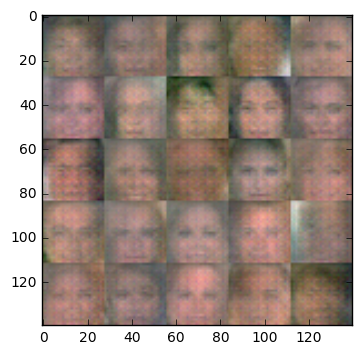

Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 1.0041
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 0.9145... Generator Loss: 1.7386
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.4401
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 1.4179
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 0.7565... Generator Loss: 1.2880
Epoch 1/1... Discriminator Loss: 1.6142... Generator Loss: 0.3258


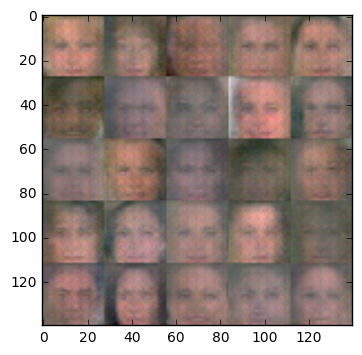

Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 1.2416
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 1.7589
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.4457
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 1.5259
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.5865
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 1.4699
Epoch 1/1... Discriminator Loss: 0.9389... Generator Loss: 0.9384


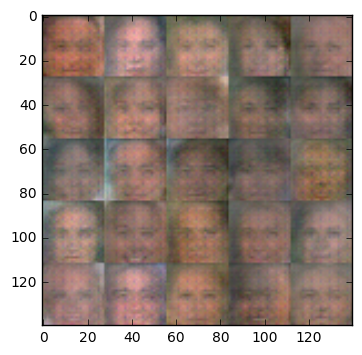

Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.5593
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 1.6169
Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 0.7918... Generator Loss: 1.3242
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 1.5641
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 0.7570


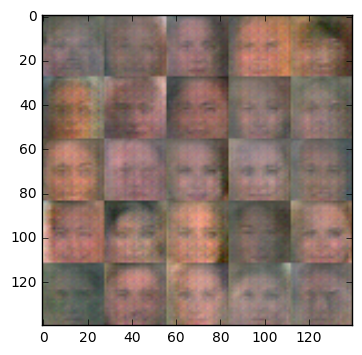

Epoch 1/1... Discriminator Loss: 0.8291... Generator Loss: 1.4743
Epoch 1/1... Discriminator Loss: 0.7402... Generator Loss: 1.5074
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 1.2109
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 1.5228
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 0.7832


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.